In [1]:
 import numpy as np
 import cv2
 import os
 import random
 import matplotlib.pyplot as plt
 import pickle
 from sklearn.model_selection import train_test_split
 from tensorflow.keras.models import Sequential
 from tensorflow.keras.models import Model
 import tensorflow as tf
 from sklearn.metrics import classification_report,confusion_matrix

In [2]:
 import tensorflow as tf
 from tensorflow.keras import layers as L
 import keras
 from keras.layers import *

In [3]:
 DIRECTORY = r'/kaggle/input/colorectal-polyps/archive/kvasir-train'
 CATEGORIES = ['dyed-lifted-polyps', 'dyed-resection-margins', 'esophagitis','normal-cecum','normal-pylorus','normal-z-line','polyps','ulcerative-colitis']
 IMG_SIZE = 224
 train_data=[]

In [4]:
 for category in CATEGORIES:
    folder = os.path.join(DIRECTORY,category)
    #print(folder)
    label = CATEGORIES.index(category)
    for img in os.listdir(folder):
        img_path = os.path.join(folder, img)
        #print(img_path)
        img_arr = cv2.imread(img_path)
        img_arr = cv2.resize(img_arr, (IMG_SIZE, IMG_SIZE))
        #plt.imshow(img_arr)
        #break
        train_data.append([img_arr, label])

In [5]:
 len(train_data)

4000

In [6]:
 random.shuffle(train_data)

In [7]:
X_train = []
y_train = []

for features, labels in train_data:
    X_train.append(features)
    y_train.append(labels)

In [8]:
 DIRECTORY = r'/kaggle/input/colorectal-polyps/archive/kvasir-test'
 CATEGORIES = ['dyed-lifted-polyps', 'dyed-resection-margins', 'esophagitis','normal-cecum','normal-pylorus','normal-z-line','polyps','ulcerative-colitis']
 IMG_SIZE = 224
 test_data=[]

In [9]:
for category in CATEGORIES:
    folder = os.path.join(DIRECTORY,category)
    #print(folder)
    label = CATEGORIES.index(category)
    for img in os.listdir(folder):
        img_path = os.path.join(folder, img)
        #print(img_path)
        img_arr = cv2.imread(img_path)
        img_arr = cv2.resize(img_arr, (IMG_SIZE, IMG_SIZE))
        #plt.imshow(img_arr)
        #break
        test_data.append([img_arr, label])

In [10]:
 len(test_data)

800

In [11]:
 X_test = []
 y_test = []
 for features, labels in test_data:
    X_test.append(features)
    y_test.append(labels)

In [12]:
 X_train = np.array(X_train)
 y_train = np.array(y_train)
 X_test = np.array(X_test)
 y_test = np.array(y_test)

In [13]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4000, 224, 224, 3), (800, 224, 224, 3), (4000,), (800,))

In [14]:
 from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [15]:
 datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
 )
 datagen.fit(X_train)


In [16]:
def identity_block(X, f, filters, stage, block):
    """
   
    Arguments:
    X -- input of shape (m, height, width, channel)
    f -- shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Saving the input value.we need this later to add to the output. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)


    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation 
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    
    return X

In [17]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    # First layer 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a')(X) # 1,1 is filter size
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)  # normalization on channels
    X = Activation('relu')(X)

      
    # Second layer  (f,f)=3*3 filter by default
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)


    # Third layer
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)


     ##### SHORTCUT PATH #### 
    X_shortcut = Conv2D(filters = F3, kernel_size = (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1')(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value here, and pass it through a RELU activation 
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    
    return X

In [18]:
def ResNet50(input_shape=(224, 224, 3), classes=8):
    """
    Implementation of the ResNet50 architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    """

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input) #3,3 padding

    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1')(X) #64 filters of 7*7 
    X = BatchNormalization(axis=3, name='bn_conv1')(X) #batchnorm applied on channels
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X) #window size is 3*3

    # Stage 2
    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    # convolutional_block is a function defined above. Convolutional_block have 3 layers.
    #filters=[64, 64, 256] first 64 is for 1st layer and 2nd 64 is for 2nd layer and 256 is for 3rd layer of convultional block   
    # below are the conv layers from convolutional_block function
    #X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a')(X)
    #X = Conv2D(F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b')(X)
    #X = Conv2D(F3, (1, 1), strides = (s,s), name = conv_name_base + '2a')(X)
   
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b') 
    #X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a')(X)
    #X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b')(X)
    #X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c')(X)

     ### START CODE HERE ###

    # Stage 3 
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4 
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5 
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')


   # AVGPOOL 
    X = AveragePooling2D((2,2), name="avg_pool")(X)

    ### END CODE HERE ###

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [19]:
from tensorflow.keras.initializers import glorot_uniform

In [20]:
model = ResNet50(input_shape = (224, 224, 3), classes = 8)

In [21]:
model.summary()

Model: "ResNet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1 (Conv2D)            │ (None, 112, 112, 64)   │          9,472 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_conv1                  │ (None, 112, 112, 64)   │            256 │ conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 112, 112, 64)   │              0 │ bn_conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 55, 55, 64)     │              0 │ activation[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ res2a_branch2a (Conv2D)   │ (None, 55, 55, 64)     │          4,160 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn2a_branch2a             │ (None, 55, 55, 64)     │            256 │ res2a_branch2a[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 55, 55, 64)     │              0 │ bn2a_branch2a[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ res2a_branch2b (Conv2D)   │ (None, 55, 55, 64)     │         36,928 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn2a_branch2b             │ (None, 55, 55, 64)     │            256 │ res2a_branch2b[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 55, 55, 64)     │              0 │ bn2a_branch2b[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ res2a_branch2c (Conv2D)   │ (None, 55, 55, 256)    │         16,640 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ res2a_branch1 (Conv2D)    │ (None, 55, 55, 256)    │         16,640 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn2a_branch2c             │ (None, 55, 55, 256)    │          1,024 │ res2a_branch2c[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn2a_branch1              │ (None, 55, 55, 256)    │          1,024 │ res2a_branch1[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 23,663,624 (90.27 MB)

 Trainable params: 23,611,272 (90.07 MB)

 Non-trainable params: 52,352 (204.50 KB)

In [22]:
 class_weights = {0:1.1347,
                 1:0.9095,
                 2:0.9811}

In [23]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [24]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                                                 
                                                 loss='sparse_categorical_crossentropy',
                                                 metrics=['accuracy'])

In [25]:
 filepath = "/kaggle/working/My_model.keras"
 checkpoint = ModelCheckpoint(filepath, monitor="val_accuracy",
                              verbose=1, save_best_only=True,
                              mode='max')
 reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',factor=1e-1, 
                              patience=5, verbose=1)
 callbacks = [checkpoint, reduce_lr] 

In [26]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [27]:

with tf.device('/GPU:0'):
               history= model.fit(X_train, y_train, 
                                  validation_data=[X_test, y_test],
                                  class_weight=class_weights,
                                  callbacks=callbacks,
                                  epochs=20,batch_size=32)

Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.4037 - loss: 4.1388
Epoch 1: val_accuracy improved from -inf to 0.28750, saving model to /kaggle/working/My_model.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 72s 180ms/step - accuracy: 0.4045 - loss: 4.1233 - val_accuracy: 0.2875 - val_loss: 1.6746 - learning_rate: 0.0010
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.6490 - loss: 0.8461
Epoch 2: val_accuracy improved from 0.28750 to 0.61375, saving model to /kaggle/working/My_model.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 19s 155ms/step - accuracy: 0.6490 - loss: 0.8459 - val_accuracy: 0.6137 - val_loss: 0.8588 - learning_rate: 0.0010
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.6884 - loss: 0.7367
Epoch 3: val_accuracy did not improve from 0.61375
125/125 ━━━━━━━━━━━━━━━━━━━━ 18s 144ms/step - accuracy: 0.6882 - loss: 0.7371 - val_accuracy: 0.1787 - val_loss: 5.6538 - learning_rate: 0.0010
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/s

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])


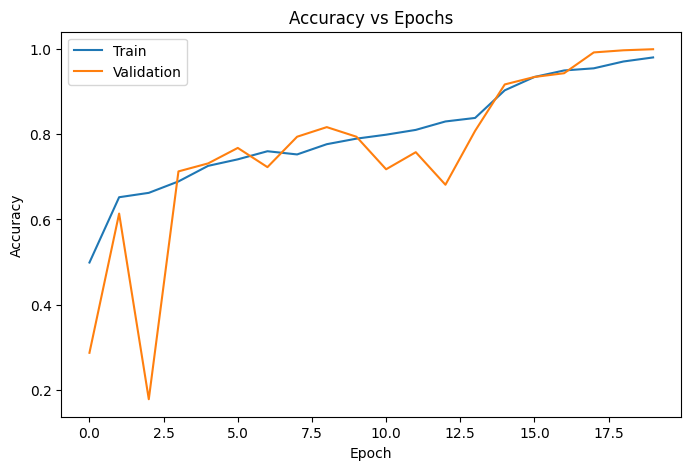

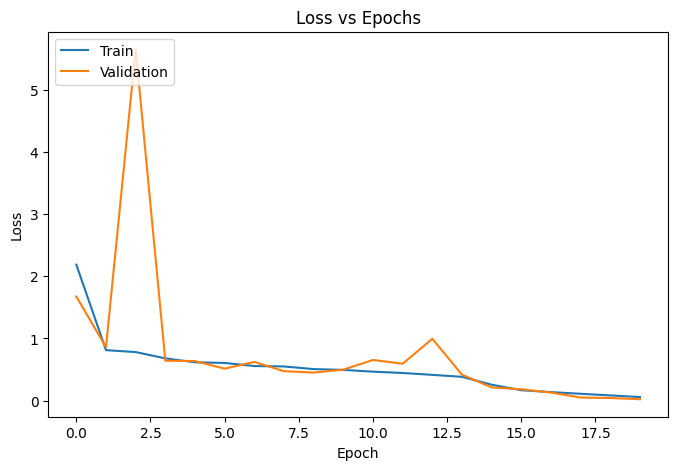

In [28]:
 print(history.history.keys())
 #  "Accuracy"
 plt.figure(figsize=(8, 5))
 plt.plot(history.history['accuracy'])
 plt.plot(history.history['val_accuracy'])
 plt.title('Accuracy vs Epochs')
 plt.ylabel('Accuracy')
 plt.xlabel('Epoch')
 plt.legend(['Train', 'Validation'], loc='upper left')
 plt.show()
 # "Loss"
 plt.figure(figsize=(8, 5))
 plt.plot(history.history['loss'])
 plt.plot(history.history['val_loss'])
 plt.title('Loss vs Epochs')
 plt.ylabel('Loss')
 plt.xlabel('Epoch')
 plt.legend(['Train', 'Validation'], loc='upper left')
 plt.show()

In [32]:
re_model = tf.keras.models.load_model('/kaggle/working/My_model.keras')
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9988 - loss: 0.0245
Test Accuracy: 0.9987


In [33]:
 y_pred = re_model.predict(X_test)

25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step


In [34]:
y_true = y_test
y_pred = np.argmax(y_pred, axis=1)
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 2, 2, 2, 2, 3,

In [35]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00       100
           2       1.00      0.99      0.99       100
           3       1.00      1.00      1.00       100
           4       1.00      1.00      1.00       100
           5       0.99      1.00      1.00       100
           6       1.00      1.00      1.00       100
           7       1.00      1.00      1.00       100

    accuracy                           1.00       800
   macro avg       1.00      1.00      1.00       800
weighted avg       1.00      1.00      1.00       800



In [37]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [40]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

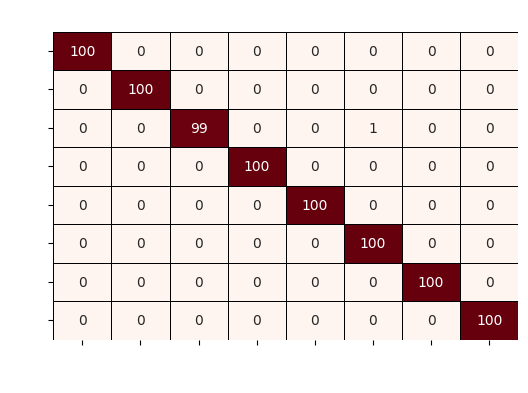

In [42]:

 # Plot heatmap with red-black color scheme
 plt.figure(figsize=(6, 4))
 sns.heatmap(cm, annot=True, fmt="d", cmap="Reds", cbar=False, 
linewidths=0.5, linecolor='black')
 # Set black background
 plt.gca().set_facecolor('black')
 plt.xlabel("Predicted", color="white")
 plt.ylabel("Actual", color="white")
 plt.title("Confusion Matrix", color="white")
 # Change tick colors to white
 plt.xticks(color="white")
 plt.yticks(color="white")
 plt.show()